# GROUP ASSIGNMENT [COSC2753]

**Members**:
- Vo Thanh Luan – s3822042

# I. Problem statement

In [8]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# Data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

# Preprocess image data
from PIL import Image
from pathlib import Path
import imageio.v2 as imageio
import imagehash
import glob

# Image reprocessing and image extraction
import os
import cv2
import pickle
import datetime
import sklearn
from sklearn.metrics.pairwise import cosine_similarity

# Deep learning
import tensorflow as tf
from tensorflow import keras
from keras.layers import Embedding
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.image import ImageDataGenerator
from keras import applications

# II. Data retrieving

In [5]:
flower_dataset_directory = "./data/Flowers/"
flower_category_foldername = os.listdir(flower_dataset_directory)
print(flower_category_foldername)

['Babi', 'Calimerio', 'Chrysanthemum', 'Hydrangeas', 'Lisianthus', 'Pingpong', 'Rosy', 'Tana']


In [6]:
link = []
for label in flower_category_foldername:
    path = os.path.join(flower_dataset_directory, label) # combine path and labels
    link.append(path) # append in link
print(link)

for i in range(len(link)):
    new = os.listdir(link[i])
    i+=1
    print(f"length : cd {len(new)}") # each folder total image count

['./data/Flowers/Babi', './data/Flowers/Calimerio', './data/Flowers/Chrysanthemum', './data/Flowers/Hydrangeas', './data/Flowers/Lisianthus', './data/Flowers/Pingpong', './data/Flowers/Rosy', './data/Flowers/Tana']
length : cd 931
length : cd 353
length : cd 696
length : cd 518
length : cd 969
length : cd 360
length : cd 171
length : cd 623


In [7]:
def create_flower_csv(input_dir, flower_categories):
    # Initialize an empty list to store the data
    data = []

    # Loop over each flower category
    for category in flower_categories:
        # Get the path to the category directory
        category_dir = os.path.join(input_dir, category)
        # Loop over each image file in the category directory
        for filename in os.listdir(category_dir):
            # Get the full path to the image file
            filepath = os.path.join(category_dir, filename)
            # Add a row of data to the list
            data.append((filename, category, len(data) + 1))

    # Create a pandas DataFrame from the data
    df = pd.DataFrame(data, columns=["id","file_name", "flower_category"])

    # Write the DataFrame to a CSV file
    df.to_csv("flower_data.csv", index=False)

In [8]:
create_flower_csv(flower_dataset_directory, flower_category_foldername)

Raw images memory is about ~1000kb, which is a very good image for viewing but a very computationally expensive image to fit into CNN models. Therefore, they are downscaled to only 224 x 224 pixels dimension, which is the appropriate data format for Keras CNN models like ResNet and VGG to train.

In [11]:
data_generators = {}

def process_images():

    for category in flower_category_foldername:
        data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
            rescale=1./255,
        ).flow_from_directory(
            flower_dataset_directory,
            target_size=(224, 224),
            class_mode="categorical",
            shuffle=True,
            classes=[category]
        )
    data_generators[category] = data_generator

In [12]:
process_images()

Found 931 images belonging to 1 classes.
Found 353 images belonging to 1 classes.
Found 696 images belonging to 1 classes.
Found 518 images belonging to 1 classes.
Found 969 images belonging to 1 classes.
Found 360 images belonging to 1 classes.
Found 171 images belonging to 1 classes.
Found 623 images belonging to 1 classes.


## Explanatory Data Analysis

KeyError: 'Babi'

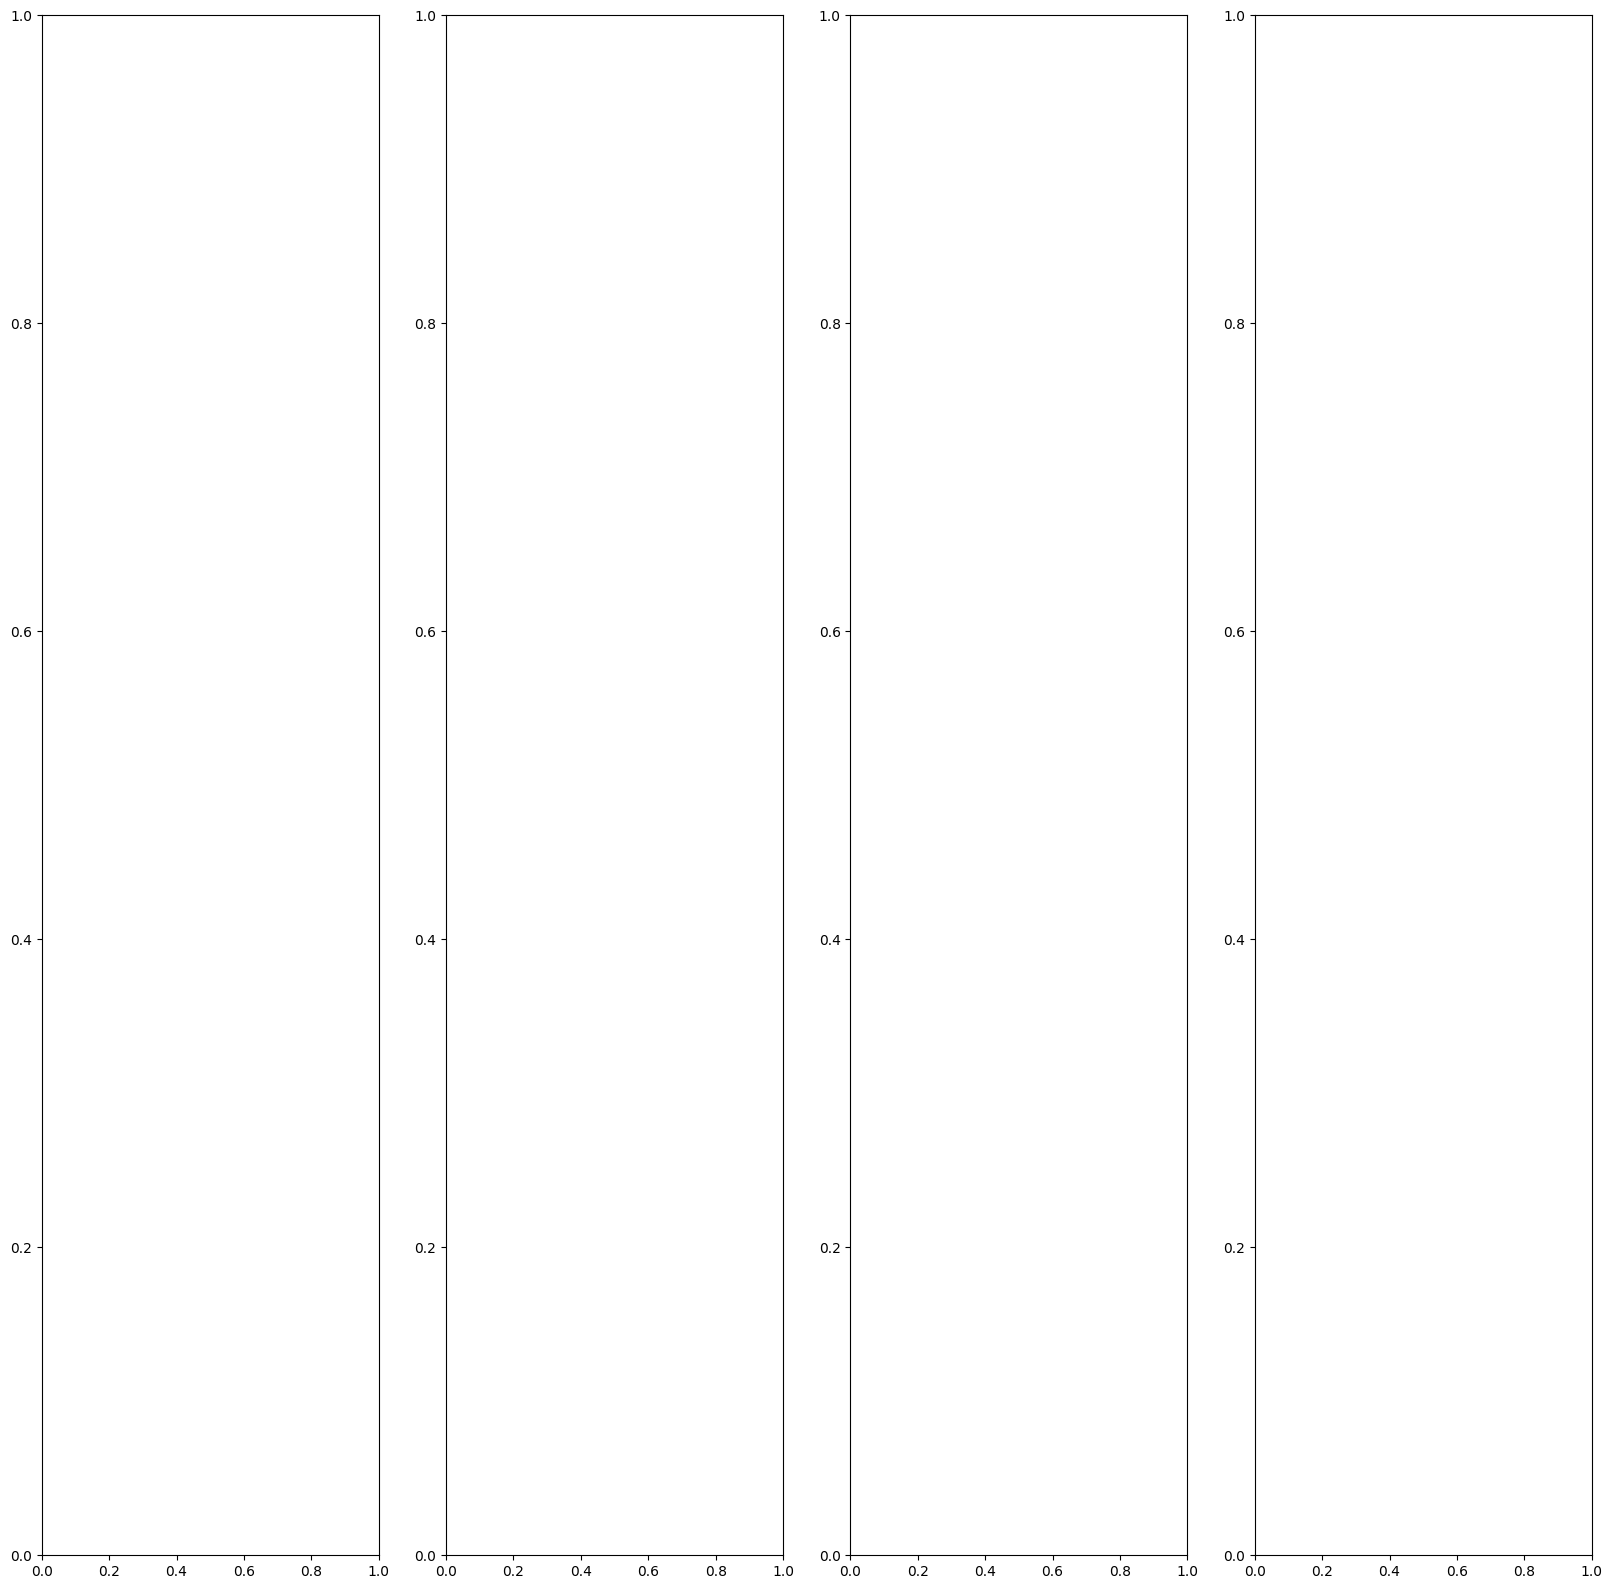

In [13]:
fig_dict = {}
for category in flower_category_foldername:
    fig_dict[category], ax = plt.subplots(ncols=4, figsize=(20,20))
    batch = data_generators[category].next()
    for idx, img in enumerate(batch[0][:4]):
        ax[idx].imshow(img)
        ax[idx].set_title(category)

In [ ]:
total_sizes = {}
for category in flower_category_foldername:
    total_sizes[category] = len(data_generators[category].filenames)

fig, ax = plt.subplots()
ax.bar(total_sizes.keys(), total_sizes.values())

# set chart title and axis labels
ax.set_title("Number Of Images In Each Flower Category")
ax.set_xlabel("Flower Categories")
ax.set_ylabel("Number of Images")

fig.set_size_inches(10, 6)
ax.tick_params(axis='x', labelsize=8)

# show the chart
plt.show()

### Data cleaning

#### Detect corrupt image

It is crucial to detect corrupted images, as they can negatively impact the performance of a machine learning model or computer vision system. Images that have been corrupted may contain noise, artifacts, or other anomalies that can lead to misclassifications or output errors. Improve the accuracy and dependability of a model or system by detecting and removing these images from the dataset. In addition, corrupted images can cause biases in the model or system, which can lead to erroneous results or unjust decisions.

In [6]:
corrupted_image = list()
accu = 0

for root, dirs, files in os.walk(flower_dataset_directory):
    for name in dirs:
        print(os.path.join(root, name))
        for image_file in Path(os.path.join(root, name)).glob('*.jpg'):
          accu = accu + 1
          try :
              image = imageio.imread(image_file)
            #   print(f'read {image_file}')
          except :
              print(f'Cannot read image {image_file}')
              corrupted_image.add(image_file)
print("Total number of images : ", accu)

./data/Flowers/Babi
./data/Flowers/Calimerio
./data/Flowers/Chrysanthemum
./data/Flowers/Hydrangeas
./data/Flowers/Lisianthus
./data/Flowers/Pingpong
./data/Flowers/Rosy
./data/Flowers/Tana
Total number of images :  4621


In [7]:
len(corrupted_image)

0

#### Image duplication detection

Duplicate image detection is essential for multiple reasons:

1. Reducing storage: Storing duplicate images wastes storage space, and detecting and removing them can help reduce storage costs.

2. Improving efficiency: Processing or analyzing duplicate images is inefficient and time-consuming. Removing duplicates can improve processing and analysis efficiency.

3. Enhancing accuracy: Duplicate images can bias the results of image-based analysis, such as object detection or image classification. Removing duplicates can improve the accuracy of these analyses.

4. Maintaining data integrity: Duplicates can lead to confusion and inconsistency in data, especially when dealing with large image datasets. Removing duplicates helps to maintain data integrity and consistency.

In [ ]:
# Define a function to compute the hash of an image file
def compute_hash(filepath):
    with Image.open(filepath) as img:
        return str(imagehash.phash(img))

# Define a function to find and remove duplicated images
def remove_duplicates(rootdir):
    hashes = {}
    duplicated = []
    rootdir = glob.glob(rootdir)
    for folder in rootdir:
        print()
        print(folder)
        for image_dir in glob.glob(folder+'/*.jpg'):
            # Compute the hash of the image file
            file_hash = compute_hash(image_dir)
            # Check if this hash has already been seen
            file=os.path.basename(image_dir).split('/')[-1]
            if file_hash in hashes:
                # This file is a duplicate, so remove it
                os.remove(image_dir)
                print(f'Removed duplicate file: {file}')
                duplicated.append(file)
            else:
                # This file is not a duplicate, so remember its hash
                hashes[file_hash] = file
        print(r'Duplicated image in ',folder,' :',len(duplicated))

# Usage: specify the root directory to search for duplicates
remove_duplicates('./data/Flowers/*')

## Task 1: Classification

## Task 2: Recommender

### Feature engineering

Resnet50 For Feature Extraction

In [ ]:
# display a single image
def display_image(path):
    img = Image.open(path)
    display(img)

Recommender using ResNet50 Features

Recommender using VGG16 Features